<a href="https://colab.research.google.com/github/ThakurGumansingh/Cryptocurrency_price_prediction/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read the dataset into a dataframe
df = pd.read_csv('/content/drive/MyDrive/data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Here I start cleaning the data. Firstly, converting Timestamp to datetime64
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
# sets the index as the date
df.index = df.Timestamp
# Resamples the data to the average daily value of each column. Removes excessive frequency
df = df.resample('D').mean()
# drops any missing values that are present
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [5]:
print(df.shape)

(3376, 7)


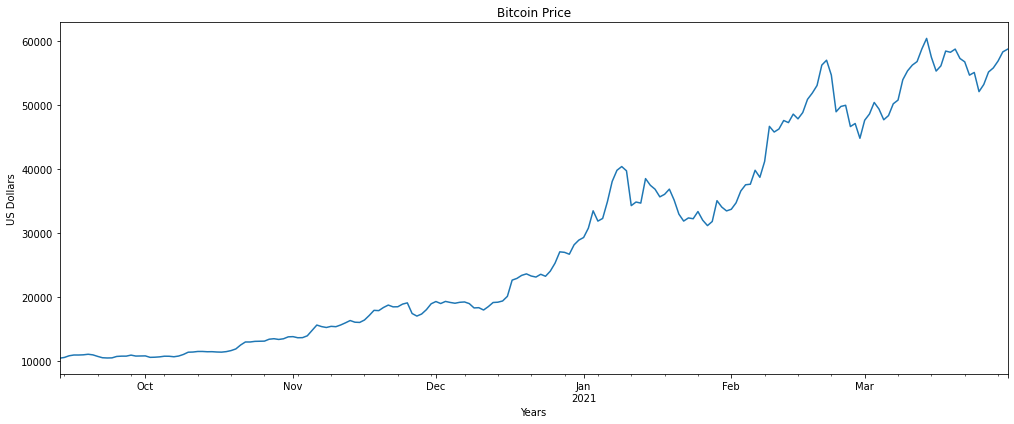

In [6]:
# let's look at the past 200 days to possibly adjust our data to this period
df.Weighted_Price.iloc[-200:].plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.show()

In [7]:
# Since the first couple years of bitcoin don't properly represent the movement and volatility of the price -
# I decide to simply focus on the previous 4 years of data from March 31st, 2021.
df2 = pd.read_csv('/content/drive/MyDrive/data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df2.Timestamp = pd.to_datetime(df2.Timestamp, unit='s')
df2.index = df2.Timestamp
df2 = df2.resample('D').mean()
df2 = df2.dropna()
# changes data to strictly to the previous 4 years, which is March 2017 to March 2021
df2 = df2.iloc[(-365*4):]
print(df2.shape)

(1460, 7)


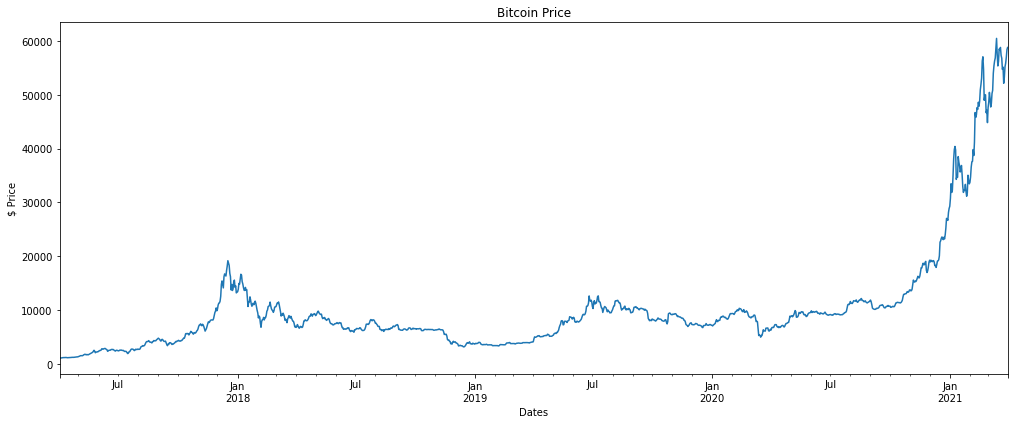

In [8]:
df2.Weighted_Price.plot(title = "Bitcoin Price", figsize=(14,6))
plt.tight_layout()
plt.xlabel('Dates')
plt.ylabel('$ Price')
plt.show()
# This data looks much more relevant for training a model. 
# However the recent spike will be involved in the testing data split - a tough prediction.

In [9]:
# splitting data again, 70, 30
df5 = df2.copy()
X = df5
size = int(len(X) * 0.7)
data_train, data_test = X[0:size], X[size:len(X)]

In [10]:
# a method to create a variety of features from a time series df
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [11]:
# assigning training and testing, features and labels (price)
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [12]:
# import XGBoost, then create model, and fit it to the training data
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)

[09:19:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, colsample_bytree=0.3, max_depth=5, min_child_weight=10)

In [13]:
# assign predictions to data_test and then data_all
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


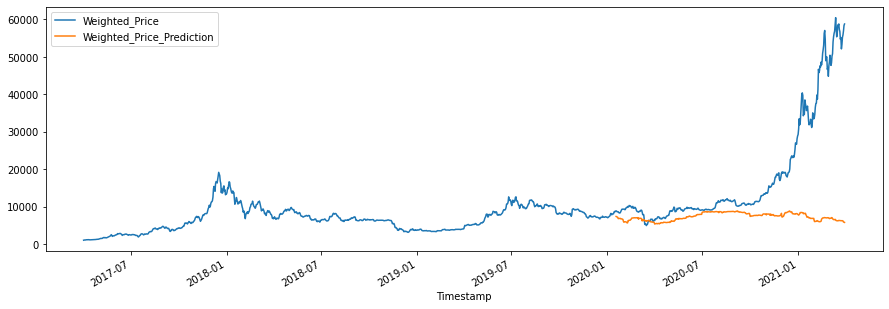

In [14]:
data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

In [15]:
data_test.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Weighted_Price_Prediction
Timestamp,,,,,,,,,,,,,,,,,
2020-01-18,8891.207561,8895.987338,8886.848700,8890.932203,2.555948,22739.596158,8891.817032,2020-01-18,0,5,1,1,2020,18,18,3,7409.640137
2020-01-19,8846.440862,8852.059917,8841.301460,8846.728456,6.109492,53655.111012,8847.166822,2020-01-19,0,6,1,1,2020,19,19,3,7337.379395
2020-01-20,8644.165698,8648.276386,8640.256435,8644.101508,3.071715,26529.821802,8644.708000,2020-01-20,0,0,1,1,2020,20,20,4,7246.419922
2020-01-21,8645.480195,8649.571579,8642.046356,8645.604819,2.360702,20386.559122,8646.193567,2020-01-21,0,1,1,1,2020,21,21,4,7198.488281
2020-01-22,8665.194124,8668.595431,8662.189026,8665.453755,2.186239,18933.853843,8665.685486,2020-01-22,0,2,1,1,2020,22,22,4,6861.897949


In [16]:
rmse = np.sqrt(mean_squared_error(data_test['Weighted_Price'], data_test['Weighted_Price_Prediction']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18483.212


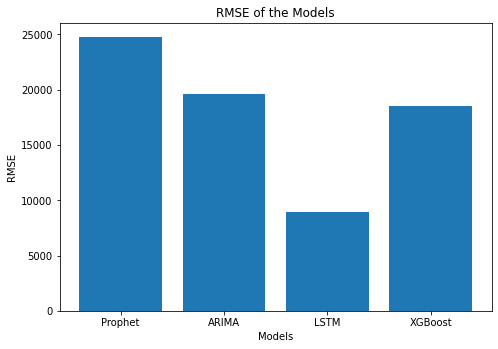

In [17]:
# # Final graph for the RMSE's of each model
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# modelz = ['Prophet', 'ARIMA', 'LSTM', 'XGBoost']
# nums = [24810,19633,8950, 18483]
# ax.bar(modelz,nums)
# plt.xlabel('Models')
# plt.ylabel('RMSE')
# plt.title('RMSE of the Models')
# plt.show()
# plt.show()